# Analysis of Money Supply in the Eurozone
Money supply in the Eurozone is not much different from that in the US and is made up of the following money aggregates:

Type of money | MB | M1 | M2 | M3
--- | --- | --- | --- | ---
Currency in circulation | ✓ | ✓ | ✓ | ✓
Reserve balances | ✓ |  |   |  
Overnight deposits (aka Demand deposits) |  | ✓ | ✓ | ✓ 
Deposits with an agreed maturity of up to 2 years or redeemable at notice of up to 3 months |  |  | ✓ | ✓
Repurchase agreements, Money market funds, Debt securities with maturity of up to 2 years |  |  |  | ✓

As you can see from the above table, `MB` currency in circulation < `M1` < `M2` < `M3` as each of the larger money supply aggregates includes the preceeding one. I use both nominal and real measures by deflating nominal measures with Eurozone's Harmonized Index of Consumer Prices (HICP).

I make use of the datasets provided by the ECB to carry out this analysis. In contrast to the Fed, which stopped publishing data on M3 in 2006, the ECB still does it.

Analogously with [the Money supply analysis for the US](./Money_Supply.ipynb) I use not seasonally adjusted datasets.

In [1]:
# Uncomment if running in Google Colaboratory

# Install the latest version of pandaSDMX
# !pip install pandaSDMX -U
# !pip install eurostat -U

In [2]:
import pandas as pd
import numpy as np
import matplotlib.ticker as mtick
import pandas_datareader.data as web
from pandas.tseries.offsets import BDay

import eurostat
import warnings
warnings.filterwarnings('ignore', message='optional dependency requests_cache*', category=RuntimeWarning)
import pandasdmx as sdmx

from datetime import date

from dateutil.relativedelta import relativedelta

In [3]:
report_start = date.fromisoformat('2008-10-01')
report_end = date.today()

### Preparing factors for conversion from nominal to real amounts by adjusing for monthly Harmonized Index of Consumer Prices (HICP &mdash; Eurozone's CPI)

In [4]:
# Using Eurozone price index 2015=100, and All-items HICP: CP00 
eu_hicp = eurostat.get_data_df('prc_hicp_midx',
               filter_pars={'startPeriod': report_start, 'unit': 'I15', 'coicop': 'CP00', 'geo': 'EA'}).iloc[:, 3:]
eu_hicp = eu_hicp.set_index(eu_hicp.columns[0]).T
eu_hicp = eu_hicp.set_axis(pd.DatetimeIndex(eu_hicp.index, 'MS'))

## Analysis of annual changes in the main components of M3

In [5]:
# M.U2.N.V.L10.X.1.U2.2300.Z01.E <-- Currency in circulation
# M.U2.N.V.M10.X.1.U2.2300.Z01.E <-- M1
# M.U2.N.V.M20.X.1.U2.2300.Z01.E <-- M2
# M.U2.N.V.M30.X.1.U2.2300.Z01.E <-- M3
# Retrieving them all in one go                               
ecb = sdmx.Request('ECB')  
data_msg = ecb.data('BSI', key='M.U2.N.V..X.1.U2.2300.Z01.E', params={'startPeriod': report_start, 
                                                                      'endPeriod': report_end})

In [6]:
df = sdmx.to_pandas(data_msg.data[0]).loc['M', 'U2', 'N', 'V', :, 'X', '1', 'U2', '2300', 'Z01', 'E'].unstack(-2)
df.columns.names = [None]

In [7]:
m1_addons = (df.loc[:, 'M10'] - df.loc[:, 'L10']).rename('M1 Add-ons')
m2_addons = (df.loc[:, 'M20'] - df.loc[:, 'M10']).rename('M2 Add-ons')
m3_addons = (df.loc[:, 'M30'] - df.loc[:, 'M20']).rename('M3 Add-ons')

In [8]:
m3_df = pd.concat([df.loc[:, ['M30', 'L10']], m1_addons, m2_addons, m3_addons], axis=1)
m3_df = m3_df.set_axis(pd.DatetimeIndex(m3_df.index, 'MS'))
m3_df.rename(columns={'L10': 'MB Currency in circulation', 'M30': 'M3 Total'}, inplace=True)

# Converting into billions of Euros
m3_df /= 1000.

In [9]:
m3_df

,M3 Total,MB Currency in circulation,M1 Add-ons,M2 Add-ons,M3 Add-ons
TIME_PERIOD,,,,,
2008-10-01,9326.351030,698.783573,3245.683158,4027.655269,1354.229030
2008-11-01,9367.448353,703.623942,3266.057343,4049.303799,1348.463269
2008-12-01,9423.780086,722.746037,3312.996312,4067.314628,1320.723109
2009-01-01,9400.007135,712.198952,3383.950818,4005.742439,1298.114926
2009-02-01,9414.394921,715.828862,3386.039071,3991.931310,1320.595678
...,...,...,...,...,...
2023-05-01,16003.384227,1539.652162,9267.194873,4308.403789,888.133403
2023-06-01,16007.565096,1542.746202,9198.381816,4391.964941,874.472136
2023-07-01,16001.316287,1545.890936,9101.546771,4452.921655,900.956925


In [10]:
last_idx = min(eu_hicp.index[-1], m3_df.index[-1])
eu_hicp = eu_hicp.loc[:last_idx]
# Convert into pandas.Series
nom_2_real_conv_factors = (eu_hicp.iloc[-1] / eu_hicp).iloc[:,0].rename('Conversion factor')

# Convert from nominal into real money supply
m3real_df = m3_df.multiply(nom_2_real_conv_factors, axis=0).dropna()

m3real_df.rename(
    columns={m3_df.columns[0]: 'Real ' + m3_df.columns[0], m3_df.columns[1]: 'Real ' + m3_df.columns[1],
             m3_df.columns[2]: 'Real ' + m3_df.columns[2], m3_df.columns[3]: 'Real ' + m3_df.columns[3]},
    inplace=True)

In [11]:
m3real_df

,Real M3 Total,Real MB Currency in circulation,Real M1 Add-ons,Real M2 Add-ons,M3 Add-ons
TIME_PERIOD,,,,,
2008-10-01,12608.407852,944.694046,4387.878698,5445.036344,1830.798764
2008-11-01,12726.188433,955.911422,4437.116663,5501.199604,1831.960744
2008-12-01,12819.514115,983.177975,4506.790544,5532.917450,1796.628145
2009-01-01,12894.310305,976.947587,4641.880721,5494.813490,1780.668507
2009-02-01,12861.584980,977.937915,4625.876610,5453.623330,1804.147126
...,...,...,...,...,...
2023-05-01,16169.720661,1555.655043,9363.516509,4353.184599,897.364510
2023-06-01,16132.026605,1554.741313,9269.900781,4426.113207,881.271304
2023-07-01,16140.108509,1559.299685,9180.491770,4491.545408,908.771646


## Visualization of Eurozone's Nominal M3 Money Supply

In [12]:
M3_COMPOSITION_TITLE = 'Composition of Eurozone M3 Money Supply'
REALM3_COMPOSITION_TITLE = 'Composition of Eurozone Real M3 Money Supply'
IN_EURO_FORMATER = ' in {:%Y-%m} Euros'
LEFT_Y_AXIS_LABEL = 'Billions of Euros'

### Stacked Visualization Amounting to Total Eurozone M3 Money Supply

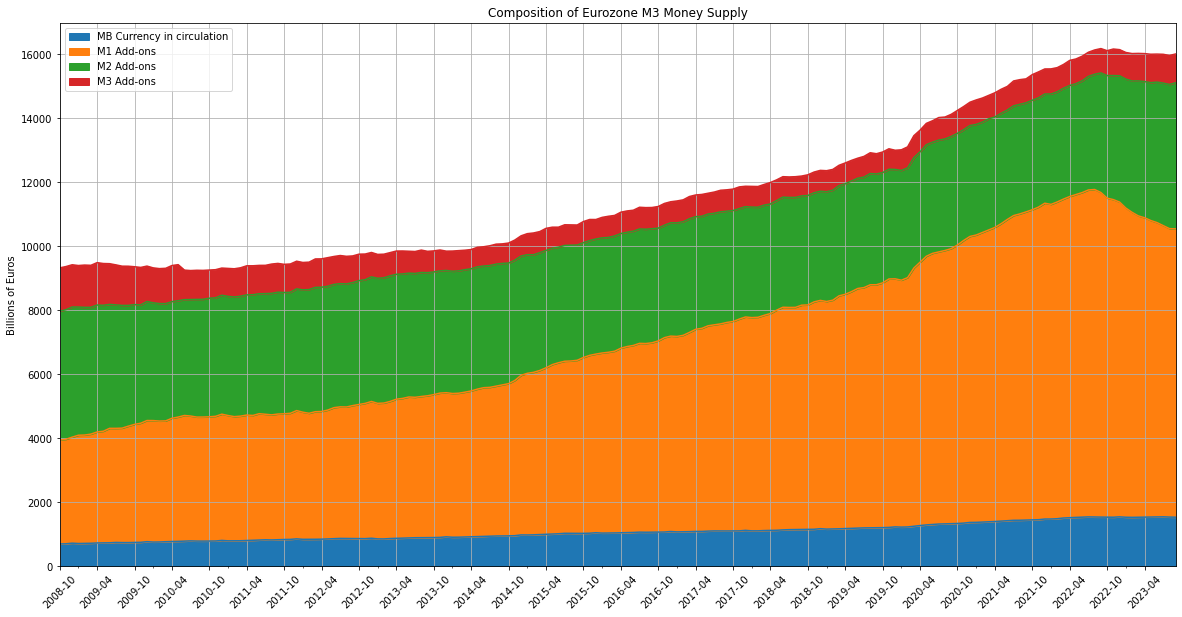

In [13]:
ax = m3_df.iloc[:,1:].plot.area(figsize=(20,10), grid=True, title=M3_COMPOSITION_TITLE,
                     xticks=m3_df.index[::6], xlabel='', rot=45,
                     ylabel=LEFT_Y_AXIS_LABEL)#, yticks=np.arange(0, 25e3, 2.5e3))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, m3_df.index[::6])))

In [14]:
idxmax = m3_df.iloc[:,0].idxmax()
print('Nominal M3 money supply maximum of \u20ac{:>8.2f}bn reached in month {:%Y-%m}'
      .format(m3_df.loc[idxmax, m3_df.columns[0]], idxmax))
print('Nominal M3 money supply changed by  \u20ac{:>8.2f}bn since (as of month {:%Y-%m})'
      .format(m3_df.iloc[-1,0]-m3_df.loc[idxmax, m3_df.columns[0]], m3_df.index[-1]))
print('Nominal M3 money supply changed by  \u20ac{:>8.2f}bn since {:%Y-%m} to \u20ac{:.2f}bn'
      .format(m3_df.iloc[-1,0]-m3_df.iloc[-2,0], m3_df.index[-2], m3_df.iloc[-1,0]))

Nominal M3 money supply maximum of €16179.93bn reached in month 2022-09
Nominal M3 money supply changed by  € -168.08bn since (as of month 2023-09)
Nominal M3 money supply changed by  €   47.49bn since 2023-08 to €16011.86bn


In [15]:
m3_df.iloc[-1,:] - m3_df.iloc[-2,:]

M3 Total                      47.486954
MB Currency in circulation    -3.910404
M1 Add-ons                    -4.211635
M2 Add-ons                    60.316165
M3 Add-ons                    -4.707172
dtype: float64

### Visualization as Percent of Total Eurozone M3 Money Supply

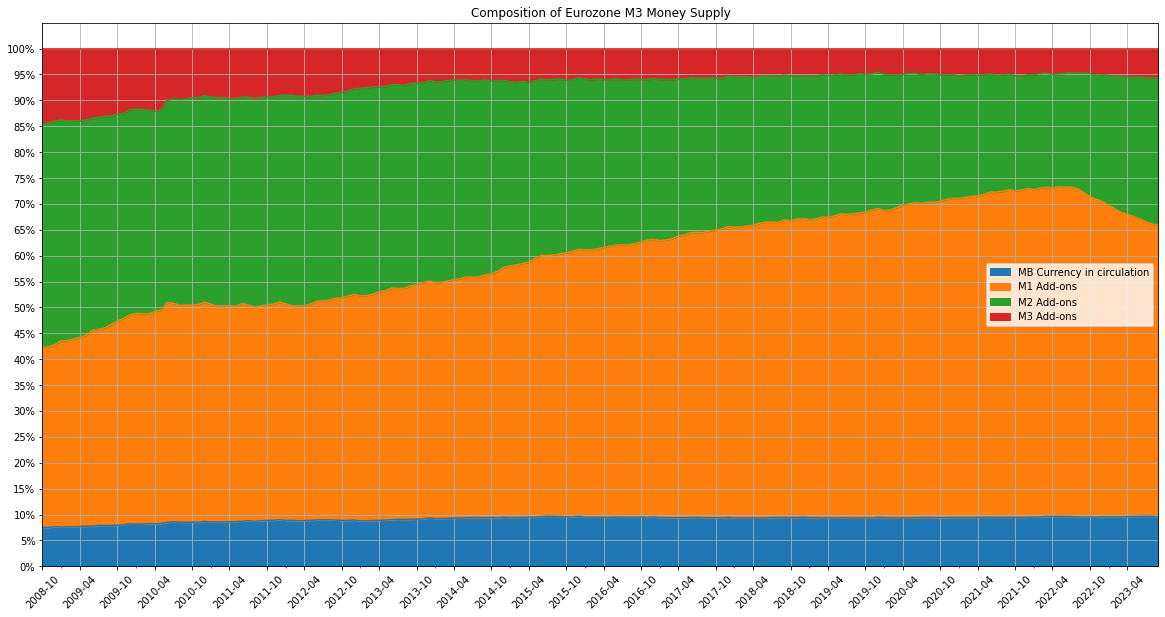

In [16]:
# Converting to percentages by dividing by total M3 Money Supply.
# Dividing by the total M3 Money Supply
m3_df_pct = m3_df.iloc[:,1:].divide(m3_df.iloc[:,0], axis=0)
m3_df_pct *= 100

ax = m3_df_pct.plot.area(figsize=(20,10), grid=True, title=M3_COMPOSITION_TITLE,
                         xticks=m3_df_pct.index[::6], xlabel='', rot=45,
                         yticks=np.arange(0, 101, 5))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, m3_df_pct.index[::6])))

In [17]:
m3_df_pct.iloc[-1,:] - m3_df_pct.iloc[-2,:]

MB Currency in circulation   -0.052998
M1 Add-ons                   -0.193774
M2 Add-ons                    0.292997
M3 Add-ons                   -0.046225
dtype: float64

## Visualization of Eurozone's Real M3 Money Supply

### Stacked Visualization Amounting to Total Eurozone Real M3 Money Supply

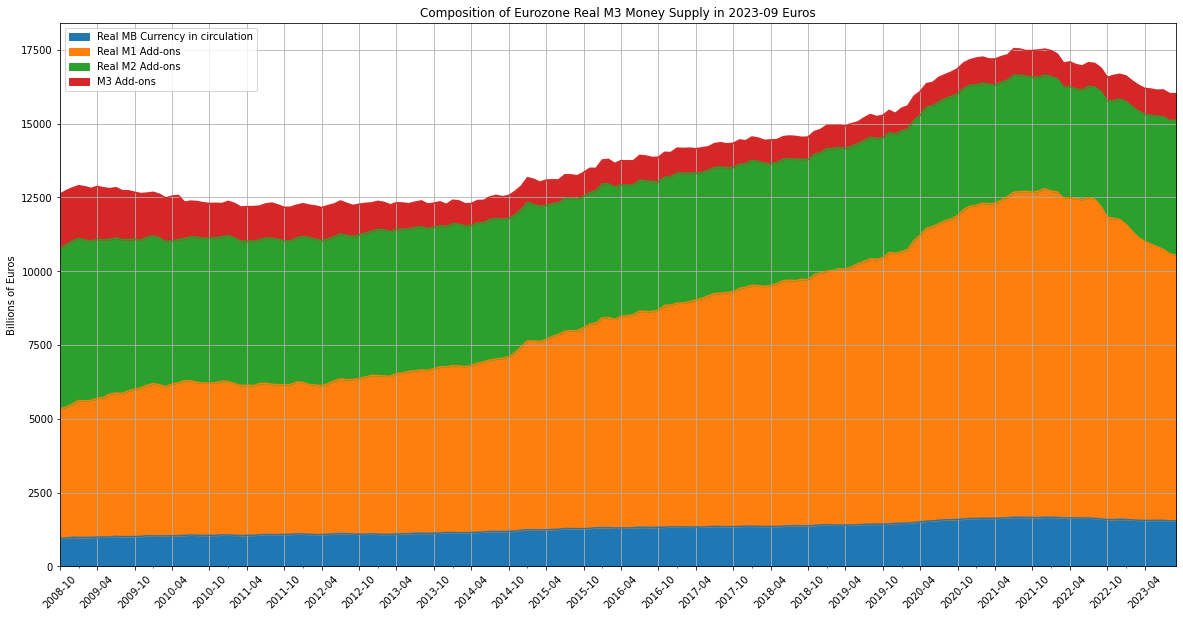

In [18]:
ax = m3real_df.iloc[:,1:].plot.area(
                figsize=(20,10), grid=True,
                title=REALM3_COMPOSITION_TITLE + IN_EURO_FORMATER.format(m3real_df.index[-1].date()),
                xticks=m3real_df.index[::6], xlabel='', rot=45,
                ylabel=LEFT_Y_AXIS_LABEL)
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, m3real_df.index[::6])))

In [19]:
idxmax = m3real_df.iloc[:,0].idxmax()
print('Real M3 money supply maximum of \u20ac{:>8.2f}bn reached in month {:%Y-%m}'
      .format(m3real_df.loc[idxmax,m3real_df.columns[0]], idxmax))
print('Real M3 money supply changed by  \u20ac{:>8.2f}bn since (as of month {:%Y-%m})'
      .format(m3real_df.iloc[-1,0]-m3real_df.loc[idxmax,m3real_df.columns[0]], m3real_df.index[-1]))
print('Real M3 money supply changed by  \u20ac{:>8.2f}bn since {:%Y-%m} to \u20ac{:.2f}bn'
      .format(m3real_df.iloc[-1,0]-m3real_df.iloc[-2,0], m3real_df.index[-2], m3real_df.iloc[-1,0]))

Real M3 money supply maximum of €17540.50bn reached in month 2021-07
Real M3 money supply changed by  €-1528.64bn since (as of month 2023-09)
Real M3 money supply changed by  €   -4.00bn since 2023-08 to €16011.86bn


In [20]:
m3real_df.iloc[-1,:] - m3real_df.iloc[-2,:]

Real M3 Total                      -3.998557
Real MB Currency in circulation    -8.871305
Real M1 Add-ons                   -33.284681
Real M2 Add-ons                    45.785778
M3 Add-ons                         -7.628350
dtype: float64

### Visualization as Percent of Total Eurozone Real M3 Money Supply

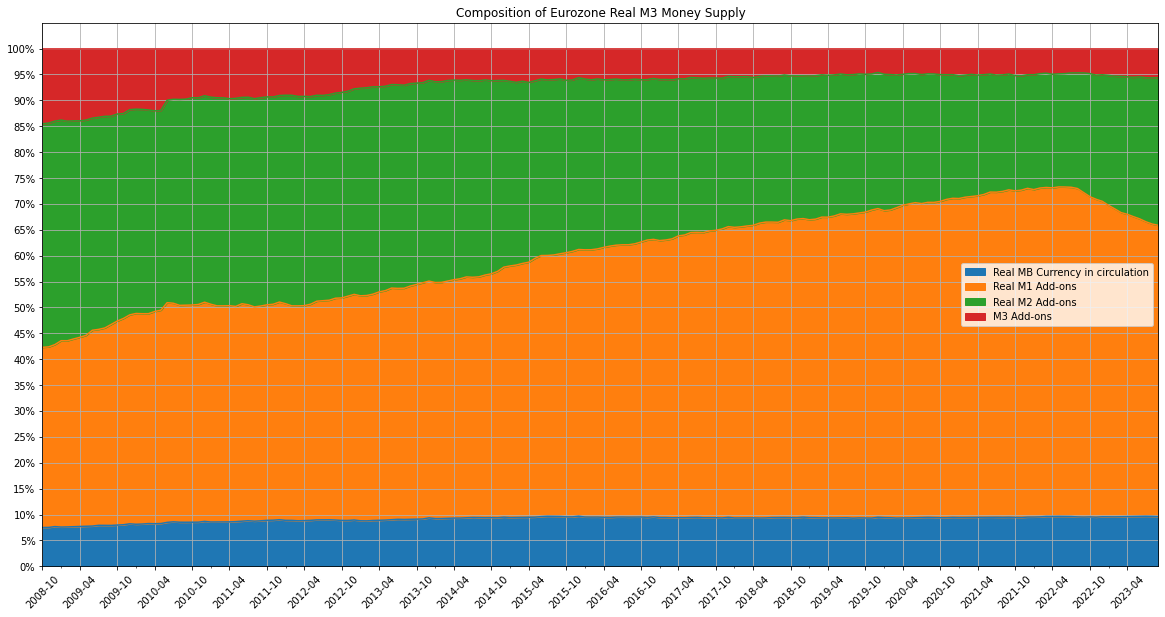

In [21]:
# Converting to percentages by dividing by total M3 Money Supply.
# Dividing by the total M3 Money Supply
m3real_df_pct = m3real_df.iloc[:,1:].divide(m3real_df.iloc[:,0], axis=0)
m3real_df_pct *= 100

ax = m3real_df_pct.plot.area(figsize=(20,10), grid=True, title=REALM3_COMPOSITION_TITLE,
                             xticks=m3real_df_pct.index[::6], xlabel='', rot=45, yticks=np.arange(0, 101, 5))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, m3real_df_pct.index[::6])))

## Visualizing Annual Percentage Changes in the Main Components of Eurozone's M3 Money Supply

In [22]:
m3_df_speed = (m3_df - m3_df.shift(1)).dropna()

In [23]:
# Converting to annual percentage changes (changes from the corresponding month a year ago)
m3_annual_rate = m3_df.pct_change(12).dropna()

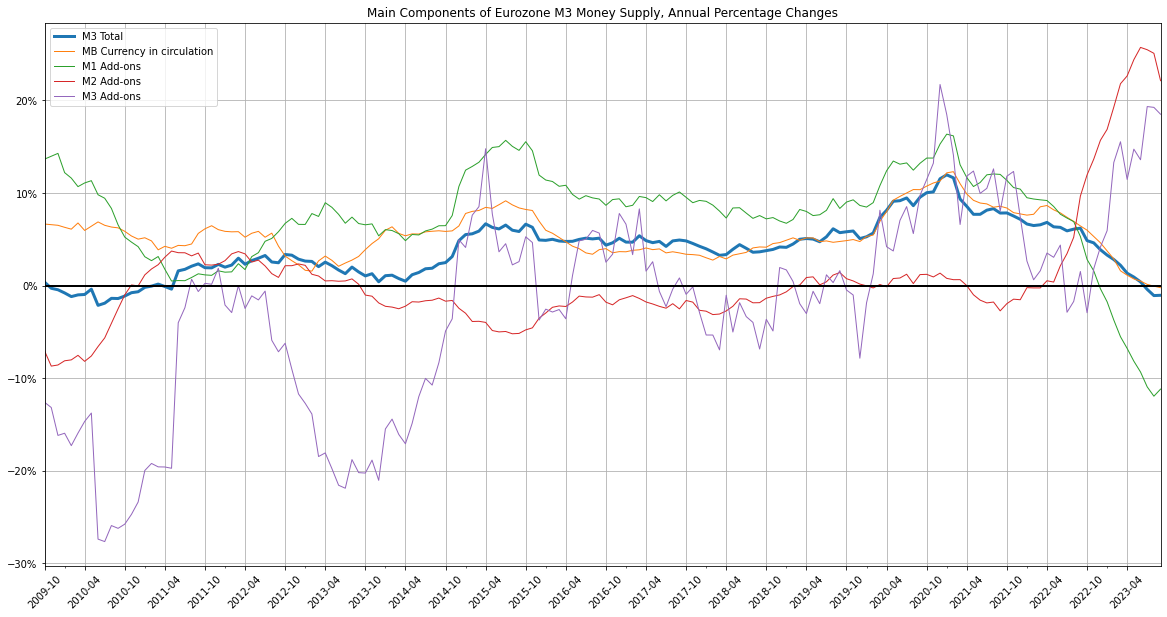

In [24]:
ax = m3_annual_rate.iloc[:,:1].plot(figsize=(20,10), grid=True, linewidth=3,
                                    title='Main Components of Eurozone M3 Money Supply, Annual Percentage Changes',
                                    xticks=m3_annual_rate.index[::6], xlabel='', rot=45)
m3_annual_rate.iloc[:,1:].plot(ax=ax, grid=True, xticks=m3_annual_rate.index[::6], xlabel='', rot=45, linewidth=1)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.axhline(y=0, lw=2, c='k')
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, m3_annual_rate.index[::6])))

In [25]:
pd.options.display.float_format = (lambda x: '{:.3%}'.format(x) if x < 100 else '{:,.0f}bn'.format(x))
m3_annual_rate.tail(12)

,M3 Total,MB Currency in circulation,M1 Add-ons,M2 Add-ons,M3 Add-ons
TIME_PERIOD,,,,,
2022-10-01,4.866%,5.995%,2.835%,11.963%,-2.922%
2022-11-01,4.622%,5.315%,1.594%,13.665%,1.830%
2022-12-01,3.884%,4.630%,-0.338%,15.703%,4.175%
2023-01-01,3.301%,3.755%,-1.740%,16.878%,5.940%
2023-02-01,2.822%,2.880%,-3.711%,19.285%,13.307%
2023-03-01,2.204%,1.604%,-5.513%,21.808%,15.542%
2023-04-01,1.345%,1.129%,-6.778%,22.649%,11.473%
2023-05-01,0.932%,0.730%,-8.154%,24.405%,14.743%
2023-06-01,0.409%,0.497%,-9.324%,25.730%,13.597%


In [26]:
M3_COMPONENTS_SPEED = 'Speed of changes in Eurozone M3 Money Supply in Billions of Euros per month'
M3REAL_COMPONENTS_SPEED = 'Speed of changes in Eurozone Real M3 Money Supply in Billions of Euros per month'
LEFT_Y_AXIS_LABEL_SPEED = 'Billions of Euros per Month'

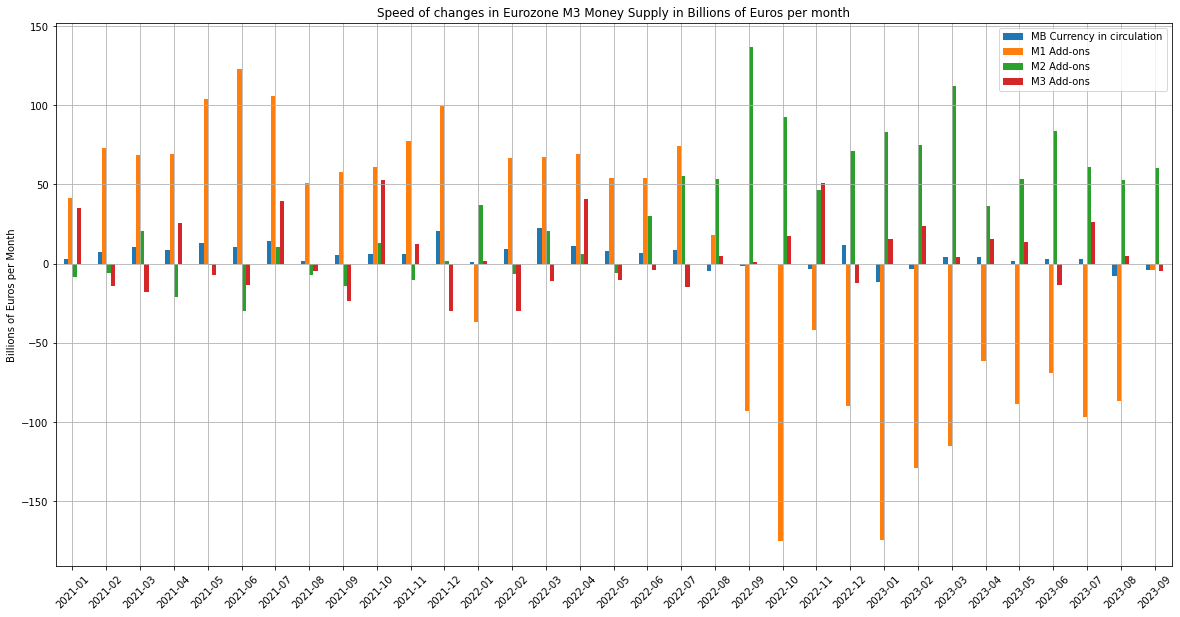

In [27]:
ax = m3_df_speed.loc['2021':, m3_df_speed.columns[1:]].plot.bar(figsize=(20,10), grid=True,
                            title=M3_COMPONENTS_SPEED, 
                            xlabel='', rot=45,
                            ylabel=LEFT_Y_AXIS_LABEL_SPEED)
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, m3_df_speed.loc['2021':].index)))